In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import statsmodels.api as sm

import patsy
from itertools import combinations

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [2]:
from sklearn.datasets import load_boston

In [3]:
# Boston House Prices dataset
boston = load_boston()

In [4]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
# Create X and y
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [6]:
# Concatenate two DataFrames
# Note: axis=0 for rows, axis=1 for columns
boston = pd.concat([y, X], axis=1)

In [7]:
# Exploratory data analysis
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

In [8]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(boston.shape[0], boston.shape[1]))

Rows: 506, Cols: 14


In [9]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
MEDV       506 non-null float64
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [10]:
# Print the first 5 rows of the DataFrame
boston.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [11]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
boston.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [12]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
boston.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,9.197104,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,25.000000,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [13]:
# Return number of unique elements for each column
# ->  excludes NA values by default
boston.nunique()

MEDV       229
CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [14]:
# Create a list of features
feature_cols = ['CRIM', 'RM', 'B', 'LSTAT']

In [15]:
# Create X and y
X = boston[feature_cols]
y = boston.MEDV

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 4 columns):
CRIM     506 non-null float64
RM       506 non-null float64
B        506 non-null float64
LSTAT    506 non-null float64
dtypes: float64(4)
memory usage: 15.9 KB


In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
# Instantiate an ordinary least squares LinearRegression model and fit linear model
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
# Predict using the linear model
y_pred = linreg.predict(X)

In [20]:
# Mean squared error (MSE) regression loss
print('MSE:', round(metrics.mean_squared_error(y, y_pred), 3))

MSE: 29.209


This is the **training MSE** because we are evaluating the model based on the same data we used to train the model.

Our goal is to estimate performance of a model on **out-of-sample data**. However, minimizing the training MSE rewards **overly complex models** that won't necessarily generalize.

**Thus, the training MSE is not a good estimate of the out-of-sample MSE.**

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


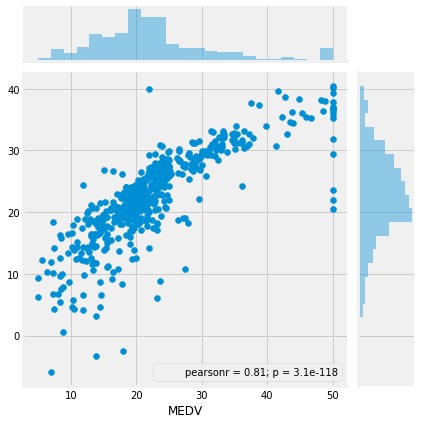

In [21]:
# Plot two variables with bivariate and univariate graphs using Seaborn's .jointplot() function
sns.jointplot(y, y_pred);

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

#### Try 70/30.

In [22]:
# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=8)

# Instantiate an ordinary least squares LinearRegression model and fit linear model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Returns the coefficient of determination R^2 of the prediction
print('R^2:', round(linreg.score(X_test, y_test), 3))

R^2: 0.616


In [23]:
# Predict using the linear model
y_pred = linreg.predict(X_test)

In [24]:
# Mean squared error (MSE) regression loss
print('Testing MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

Testing MSE: 31.179


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


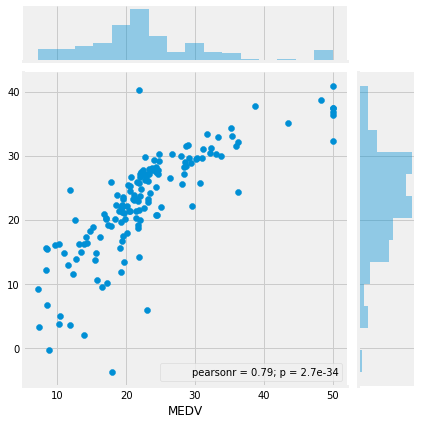

In [25]:
# Plot two variables with bivariate and univariate graphs using Seaborn's .jointplot() function
sns.jointplot(y_test, y_pred);

#### Try 90/10.

In [26]:
# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=8)

# Instantiate an ordinary least squares LinearRegression model and fit linear model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Returns the coefficient of determination R^2 of the prediction
print('R^2:', round(linreg.score(X_test, y_test), 3))

R^2: 0.584


In [27]:
# Predict using the linear model
y_pred = linreg.predict(X_test)

In [28]:
# Mean squared error (MSE) regression loss
print('Testing MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

Testing MSE: 38.143


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


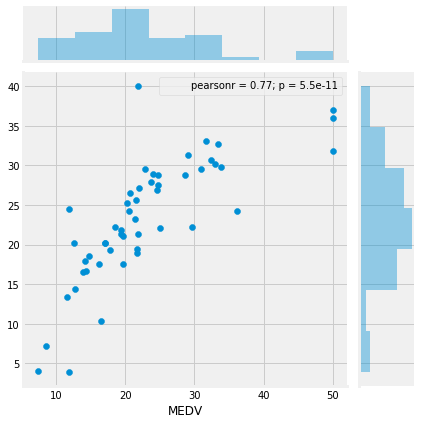

In [29]:
# Plot two variables with bivariate and univariate graphs using Seaborn's .jointplot() function
sns.jointplot(y_test, y_pred);

###### How do your metrics change?
When using the 70/30 split, the testing R^2 = 0.616 and the testing MSE = 31.179. <br>
When using the 90/10 split, the testing R^2 = 0.584 and the testing MSE = 38.143. <br>
The 90/10 split results in a decrease in R^2 (not good) and an increase in MSE (also not good) compared to the 70/30 split.

##### What does this tell us about the size of training/testing splits?
A 90/10 split will result in testing accuracy that is more variable since the proportion of test data is much smaller compared to the training data.

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [30]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [31]:
# Iterate through folds 5-10
for folds in range(5, 11):
    print('------------------------------------\n')
    print('K: {}'.format(folds))
    # Instantiate an ordinary least squares LinearRegression model
    linreg = LinearRegression()
    
    # Evaluate a score by cross-validation
    # Note: cv: number of folds in cross-validation
    scores = cross_val_score(linreg, X, y, cv=folds)
    print("Cross-validated scores: {}".format(scores))
    print("Mean CV R2: {}".format(np.mean(scores)))
    print('Std CV R2: {}'.format(np.std(scores)))
    
    # Generate cross-validated estimates for each input data point
    # Note: cv: number of folds in cross-validation
    y_pred = cross_val_predict(linreg, X, y, cv=folds)
    
    # R^2 (coefficient of determination) regression score function
    r2 = metrics.r2_score(y, y_pred)
    print("Cross-Predicted R2: {}".format(r2))

------------------------------------

K: 5
Cross-validated scores: [ 0.64631693  0.70482771  0.44121527  0.08620083 -0.50525881]
Mean CV R2: 0.2746603856925284
Std CV R2: 0.4460278043775239
Cross-Predicted R2: 0.5173431725227864
------------------------------------

K: 6
Cross-validated scores: [ 0.60617609  0.70748062  0.52005295  0.6187581  -0.31575052 -0.22205816]
Mean CV R2: 0.31910984699092365
Std CV R2: 0.42018182371554186
Cross-Predicted R2: 0.4798654514852698
------------------------------------

K: 7
Cross-validated scores: [ 0.6551403   0.59539945  0.53563504  0.49472098  0.24503727 -0.64989835
  0.11581191]
Mean CV R2: 0.2845495139064013
Std CV R2: 0.42163077886172506
Cross-Predicted R2: 0.43146848335882815
------------------------------------

K: 8
Cross-validated scores: [ 0.67247147  0.61771501  0.68493632  0.61008211  0.58758257 -0.28401756
 -1.07692607  0.03328161]
Mean CV R2: 0.23064068275695804
Std CV R2: 0.5954371664928779
Cross-Predicted R2: 0.5805843328702174
-----

##### What seems optimal?
It appears as though K=8 is optimal.
##### How do your scores change? What is the variance like? 
The cross-predictd R^2 maximizes K=8 whereas the standard deviation is the smallest at K=6
##### What are the tradeoffs associated with choosing the number of folds?
Variance appears to be the largest with a larger number of folds (K=10), but the mean R^2 is the smallest.

# kNN Practice

In [32]:
# Read file into DataFrame
# Note: header=none if column names are passed explicitly
#       names=movie_cols replaces column names during file reading
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names) # Comma-separated values file

In [33]:
# Print the first 5 rows of the DataFrame
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Map each iris species to a number. <br>
Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'.

In [34]:
# Map values of Series using input correspondence (i.e., map existing input values to new outputs values)
iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

In [35]:
# Create a custom colormap
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

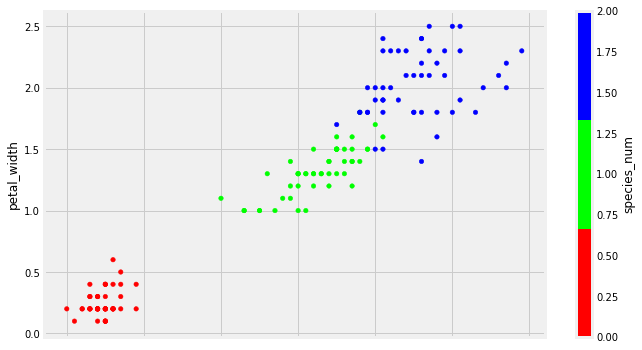

In [36]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES

# Create scatter plot
# Note: c: values of that column are used to color each point
#       colormap: colormap to select colors from
#       figsize: a tuple (width, height) in inches
iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap=cmap_bold, figsize=(10, 6));

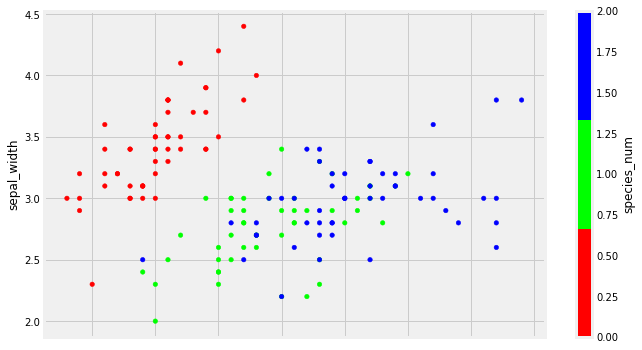

In [37]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES

# Create scatter plot
# Note: c: values of that column are used to color each point
#       colormap: colormap to select colors from
#       figsize: a tuple (width, height) in inches
iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap=cmap_bold, figsize=(10, 6));

## kNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [38]:
# Create a list of features
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
# Create X
X = iris[feature_cols]

### Create your target vector "y"
This will be the species type.

In [39]:
# Create y
y = iris.species_num

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [40]:
# Split X and y into training and testing sets
# Note: random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
# Instantiate a classifier implementing the k-nearest neighbors vote and fit the kNN model
# Note: n_neighbors: number of neighbors to use for k-neighbors queries
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [43]:
# Predict the class using the kNN model
y_pred_class = knn.predict(X_test)

# Testing accuracy classification score
print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))

Testing accuracy score: 0.921


### Create a Model With Five Neighbors. Did it Improve?

In [44]:
# Instantiate a classifier implementing the k-nearest neighbors vote and fit the kNN model
# Note: n_neighbors: number of neighbors to use for k-neighbors queries
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [45]:
# Predict the class using the kNN model
y_pred_class = knn.predict(X_test)

# Testing accuracy classification score
print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))

Testing accuracy score: 0.921


The testing accuracy score remained the same.

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [46]:
k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of k between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate a classifier implementing the k-nearest neighbors vote and fit the kNN model
    # Note: n_neighbors: number of neighbors to use for k-neighbors queries
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # TRAINING ERROR
    # Predict the class using the kNN model
    y_pred_class = knn.predict(X)

    # Training accuracy classification score
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    
    # Print training accuracy and error on each iteration
    #print(k, training_accuracy, 1 - training_accuracy)

    # Calculate training error (error = 1 - accuracy)
    training_error.append(1 - training_accuracy)
    
    # TESTING ERROR
    # Predict the class using the kNN model
    y_pred_class = knn.predict(X_test)
    
    # Testing accuracy classification score
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    
    # Calculate testing error (error = 1 - accuracy)
    testing_error.append(1 - testing_accuracy)

Create a DataFrame of k, training error, and testing error.

In [47]:
column_dict = {'k':k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('k').sort_index(ascending=False)
df.head()

,training error,testing error
k,,
100,0.220000,0.236842
99,0.220000,0.236842
98,0.220000,0.236842
97,0.213333,0.236842
96,0.213333,0.236842


Plot the relationship between k (HIGH TO LOW) and TESTING ERROR.

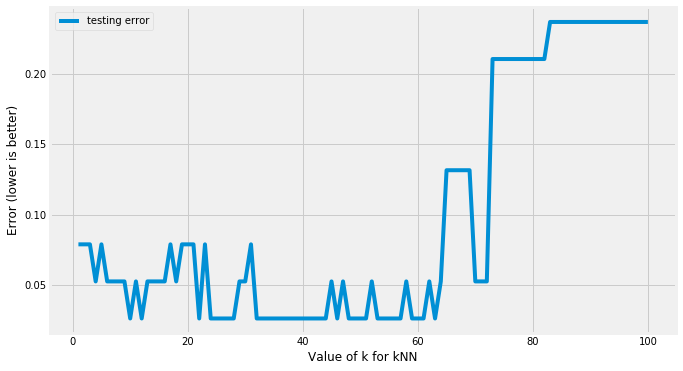

In [48]:
# Create a line plot
# Note: figsize: a tuple (width, height) in inches
df.plot.line(y='testing error', figsize=(10, 6));
plt.xlabel('Value of k for kNN');
plt.ylabel('Error (lower is better)');

Find the minimum testing error and the associated k value.

In [49]:
# Sort a DataFrame by a single column
# Note: ascending: sort ascending vs. descending; ascending=True is default
df.sort_values(by='testing error', ascending=True).head()

,training error,testing error
k,,
51,0.073333,0.026316
33,0.040000,0.026316
34,0.040000,0.026316
63,0.086667,0.026316
61,0.086667,0.026316


In [50]:
# Alternative method:
min(list(zip(testing_error, k_range)))

(0.02631578947368418, 10)

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

`knn.predict_proba(X_new)` will calculate the predicted probability estimates of class membership for the test data. Each row sums to one and contains the probabilities of each iris species.

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [51]:
# Boston House Prices dataset
boston = load_boston()

In [52]:
# First, format our data in a DataFrame
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [53]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

In [54]:
# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

# Simple ordinary least squares model
model = smf.ols(formula=formulas['case1'], data=df)

# Fit linear model
results = model.fit()

# Summarize the Regression Results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Thu, 06 Sep 2018   Prob (F-statistic):          1.59e-321
Time:                        18:12:03   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.000       4.534       5.415
LSTAT         -0.5615      0.048    -11.817      0.000      -0.655      -0.468
RAD            0.2109      0.070      3.025      0.003       0.074       0.348
TAX           -0.0174      0.004     -4.267      0.000      -0.025      -0.009
NOX            4.3456      3.385      1.284      0.200      -2.305      10.997
INDUS          0.0925      0.067      1.385      0.167      -0.039       0.224
CRIM          -0.0866      0.037     -2.362      0.019      -0.159      -0.015
ZN             0.0288      0.013      2.215      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.072   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.634
Skew:                           1.665   Prob(JB):                    2.59e-181
Kurtosis:                       8.325   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [55]:
# Create X and y
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [56]:
from itertools import combinations

In [57]:
combs = []
for i in range(1, len(X.columns)+1):
    for c in combinations(X.columns.tolist(), i):
        combs.append(c)

In [58]:
# Instantiate an ordinary least squares LinearRegression model
linreg = LinearRegression()

R2_results = {}
for i, c in enumerate(combs):
    if (i % 250) == 0:
        print(i)
        
    subX = X[list(c)]
    
    # Evaluate a score by cross-validation
    # Note: cv: number of folds in cross-validation
    R2_results[c] = np.mean(cross_val_score(linreg, subX, y))

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000


In [59]:
results = R2_results.items()
results = sorted(results, key=lambda x: x[1], reverse=True)

In [60]:
for i in range(5):
    print(results[i])

(('ZN', 'NOX', 'DIS', 'PTRATIO', 'LSTAT'), 0.5045148383236404)
(('ZN', 'NOX', 'AGE', 'DIS', 'PTRATIO', 'LSTAT'), 0.5027669995795317)
(('NOX', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'), 0.5015393804361512)
(('ZN', 'CHAS', 'NOX', 'DIS', 'PTRATIO', 'LSTAT'), 0.5010547381193208)
(('ZN', 'CHAS', 'NOX', 'AGE', 'DIS', 'PTRATIO', 'LSTAT'), 0.49868367301205874)


### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

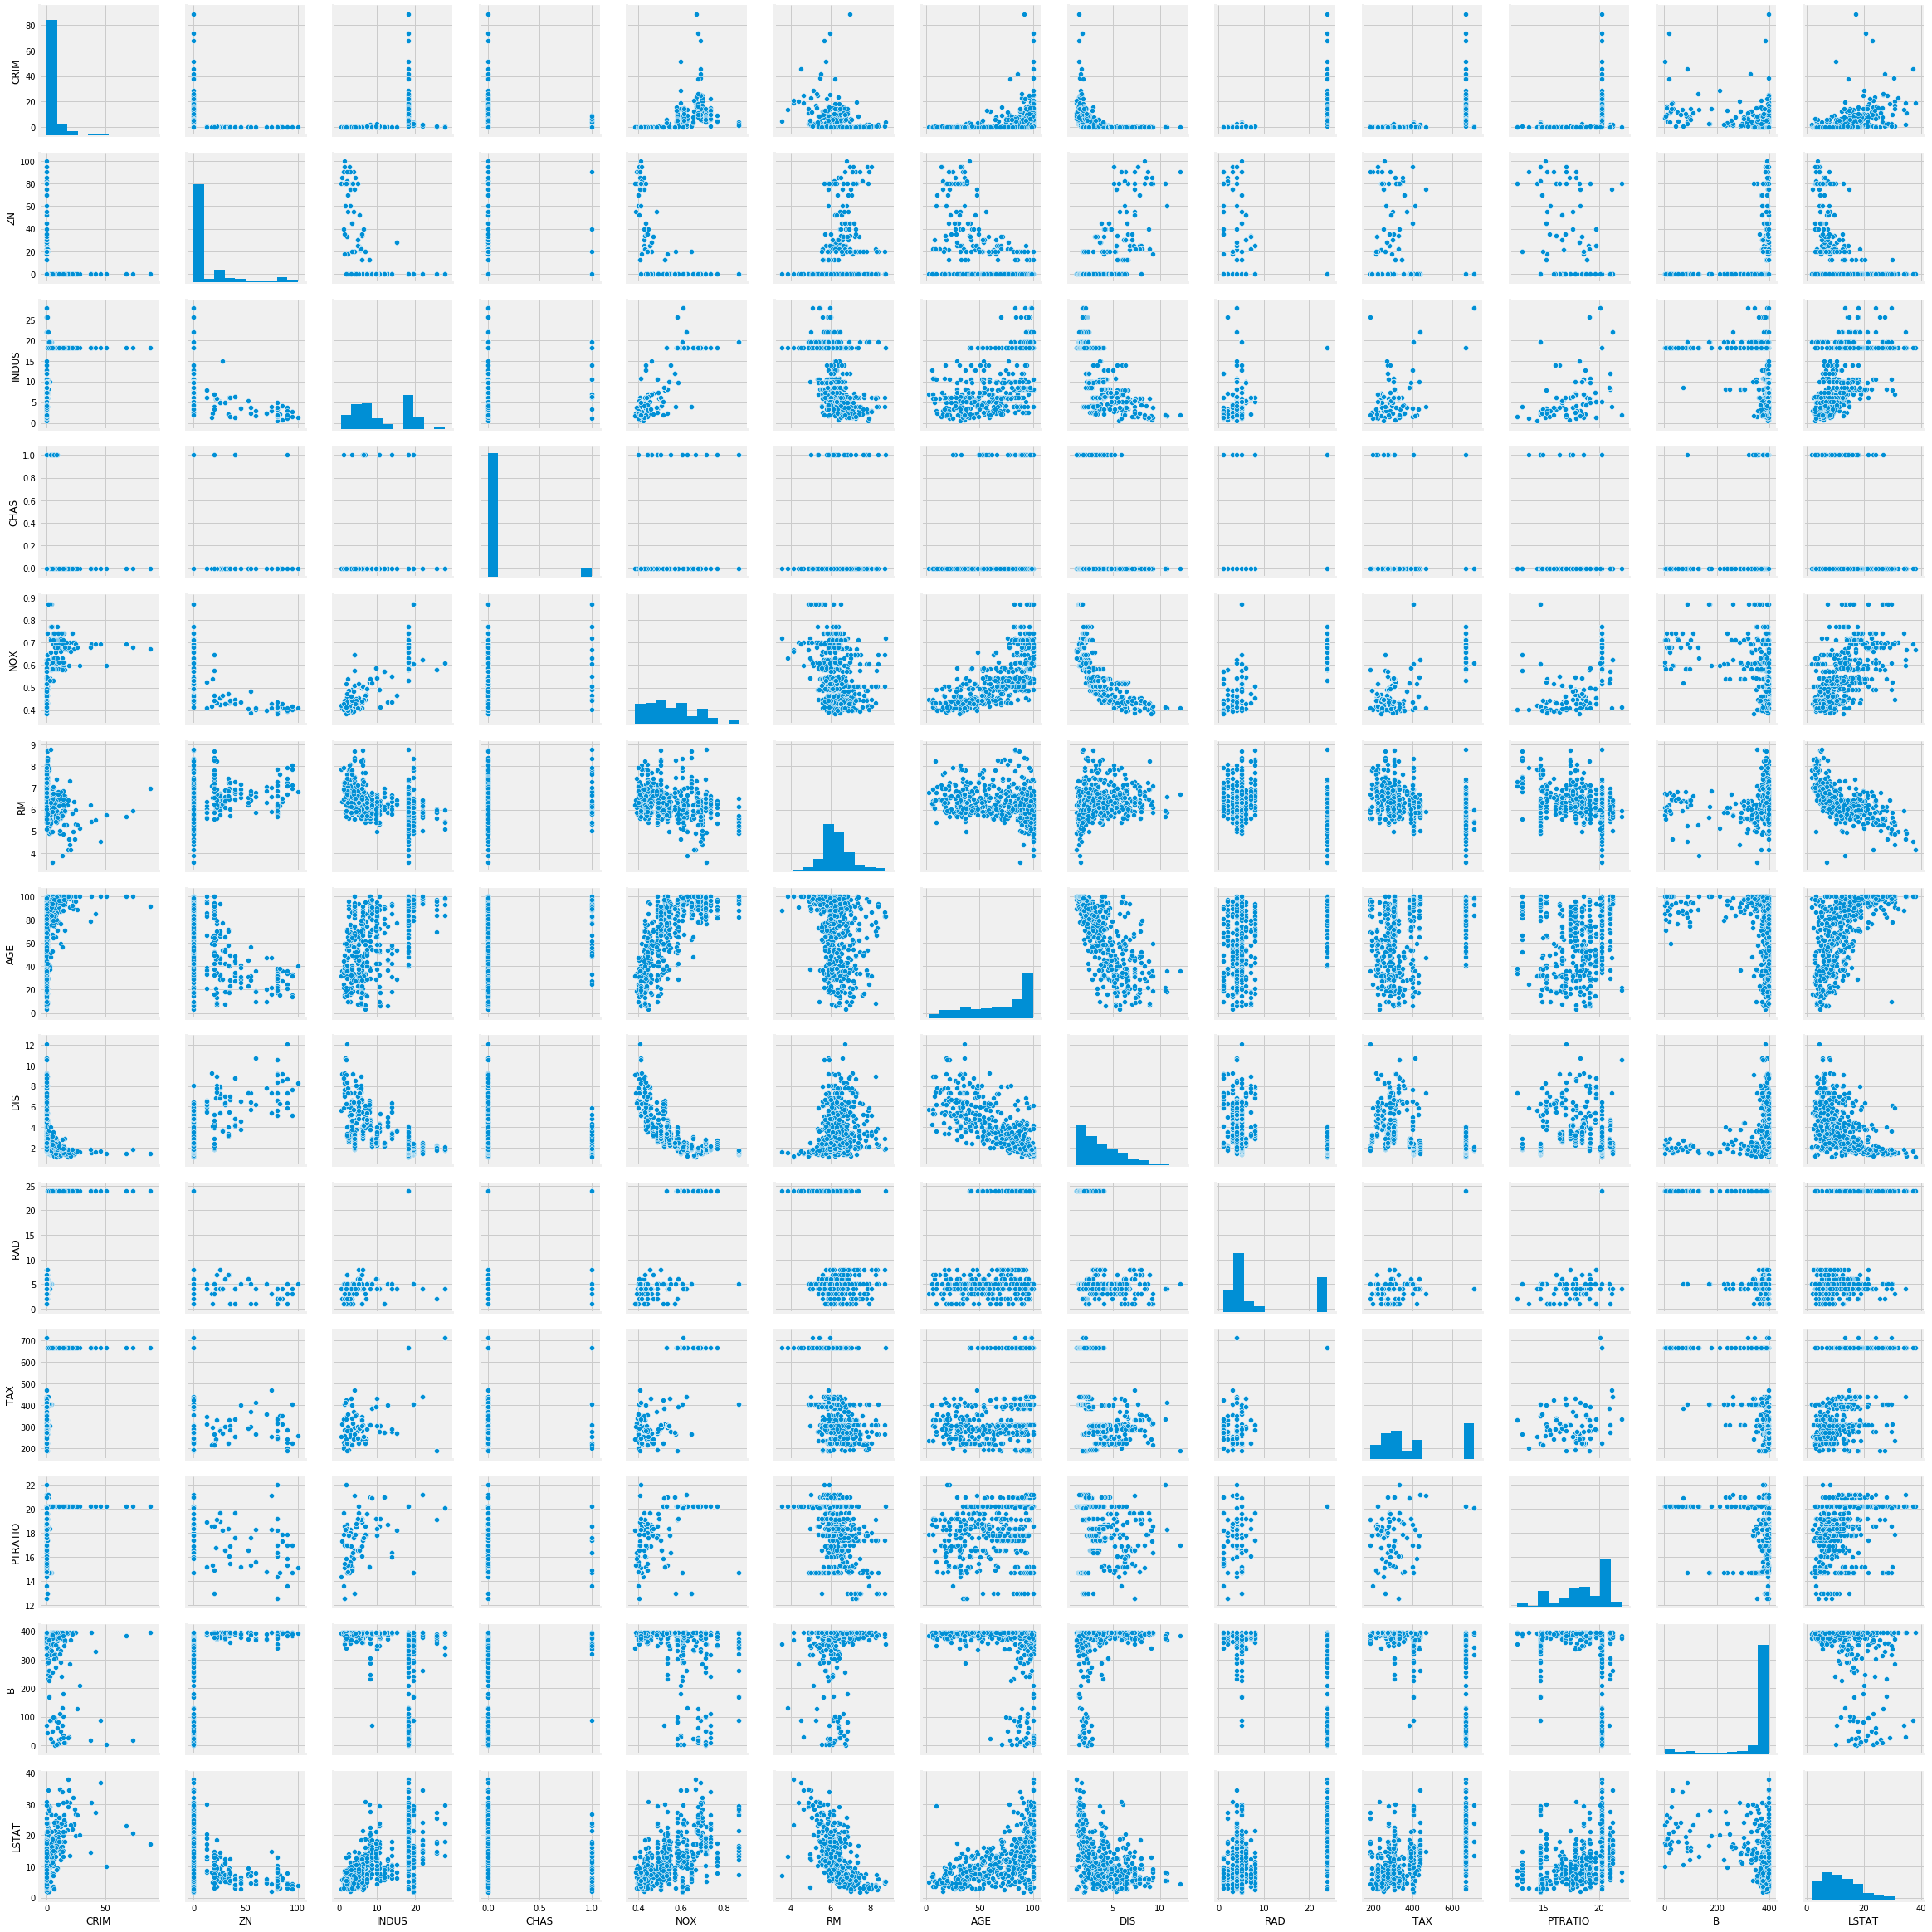

In [61]:
# Check out variable relations
import seaborn as sns

# Plot pairwise relationships in a dataset using Seaborn's .jointplot() function
sns.pairplot(X);

In [62]:
# Check out Pearson scores


## Demo: Patsy

In [63]:
import patsy

In [64]:
# Add response to the core DataFrame
df['MEDV'] = y

Easily change your variable predictors without reslicing your DataFrame.

In [65]:
# Construct two design matrices given a formula_like and data
# -> By convention, the first matrix is the "outcome" or "y" data, and the second is the "predictor" or "x" data
y, X = patsy.dmatrices('MEDV ~ AGE + RM', data=df, return_type='dataframe')

# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=99)

Rerun your model, iteratively changing your variables and train_size from the previous cell.

In [66]:
# Instantiate an ordinary least squares LinearRegression model and fit linear model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
# Predict using the linear model
y_pred = linreg.predict(X_test)

print('R^2 Score: {}'.format(metrics.r2_score(y_test, y_pred)))
print('Testing MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

R^2 Score: 0.545090688016683
Testing MSE: 38.516
